In [1]:
import numpy as np
from scipy.stats import pareto
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def randomSamplenp(c = 100):
    
    s, n = 0, 0
    
    while s <= c:
        
        s += np.random.pareto(1) * 2
        n += 1
    
    return n

In [ ]:
def cmcSingleSample(shape, scale):
    
    return([np.random.pareto(shape[i])*scale[i] for i in range(len(shape))])

In [ ]:
def cmcSample(n, shape , scale):
    
    assert len(shape) == len(scale)
    
    return(np.asmatrix([cmcSingleSample(shape , scale) for i in range(n)]))

In [ ]:
def cmc(sample, c, shape, scale):
    
    z = 0
    S = np.sum(sample)
    m = np.max(sample)
    
    def compZi(i, sample, c, shapei, scalei):
        
        ix = range(i) + range(i+1, sample.shape[1])
        
        return(pareto.sf( np.max([c - np.sum(sample[:,ix]), np.max(sample[:,ix])]), shapei, scale = scalei))
    
    return(np.sum([compZi(i, sample, c, shape[i], scale[i]) for i in range(sample.shape[1])]))

In [191]:
class CMC:
    
    def __init__(self, shape = None, scale = None, c = 100, N = 10, n = 100, K = 50, kappa = 0.01):
        
        if shape is None:
            #self.shape = np.linspace( 1, 1 + N, N, endpoint=False)
            self.shape = np.linspace( 1, 2, N, endpoint=False)
        if scale is None:
            #self.scale = np.linspace( 2, 2 + N, N, endpoint=False)
            self.scale = np.linspace( 2, 3, N, endpoint=False)
        
        assert len(self.shape) == len(self.scale)
        assert isinstance(n, int), "n must be an integer."
        
        self.c = c
        self.N = N
        self.n = n
        self.K = K
        self.kappa = kappa
        
    def takeSample(self, n = None):
        
        if n:
            self.n = n
        
        self.sample = np.asmatrix([np.random.pareto(self.shape[i], self.n)*self.scale[i] 
                                   for i in range(len(self.shape))])
        
    def cmc(self):
    
        z = 0
    
        def compZi(i, sample, c, shapei, scalei):
            
            ix = range(i) + range(i+1, sample.shape[0])
            return(pareto.sf(np.max(np.concatenate((c - np.sum(sample[ix,:], 0), 
                                                    np.max(sample[ix,:], 0))), 0), shapei, scale = scalei))
        
        self.Z = np.sum(np.concatenate([compZi(i, self.sample, self.c, self.shape[i], self.scale[i]) 
                         for i in range(self.sample.shape[0])]), 0)
        self.Zbar = np.mean(self.Z)
        
    def mc(self):
        
        self.muHat = (np.sum(self.sample, 0) > self.c).astype(int)
        self.muBar = np.mean(self.muHat)
        
        
    def compRelEff(self, mu):
        
        def mccmc(obj):
        
            obj.takeSample()
            obj.cmc()
            obj.mc()
            
            return((obj.muBar, obj.Zbar))
        
        self.muHatZbars = np.asmatrix([mccmc(self) for i in range(self.K)])
        
        self.relEff = np.log(np.mean((self.muHatZbars[:,1] - mu) > 
                              self.kappa * mu) / np.mean((self.muHatZbars[:,0] - mu) > 
                                                         self.kappa * mu))

In [183]:
def compRelEffCurve(n = np.linspace(2, 2000, 50).astype(np.int), k = 20):
    
    def compMu(n = np.int(1e6)):
    
        tmp = CMC(n=n)
        tmp.take_sample()
        tmp.cmc()
        
        return(tmp.Zbar)
    
    print("Computing Mu")
    mu = np.mean([compMu() for i in range(k)])
    
    relEffs = np.zeros((k, len(n)))
    for i in range(len(n)):
        
        print("Computing relative efficiency for n = {}".format(n[i]))
        tmp = CMC(n = n[i])
        
        for j in range(k):
            tmp.compRelEff(mu)
            relEffs[j, i] = tmp.relEff
    
    return(n, relEffs)

In [3]:
n, curveMat = compRelEffCurve()
curveMatMa = np.ma.array(curveMat, mask = np.ma.mask_or(curveMat == np.inf, curveMat == 0))
curveDf = pd.DataFrame(curveMatMa, columns=n)
curveMelt = curveDf.melt()
curveMelt = curveMelt.loc[~np.isnan(curveMelt.value), :]
smModel = sm.ols(formula="value ~ variable", data=curveMelt).fit()

Computing Mu
[0.03366787727402211]
Computing relative efficiency for n = 2


cmc.py:67: RuntimeWarning: divide by zero encountered in log
  self.kappa * mu) + epsilon)


Computing relative efficiency for n = 42
Computing relative efficiency for n = 83
Computing relative efficiency for n = 124
Computing relative efficiency for n = 165
Computing relative efficiency for n = 205
Computing relative efficiency for n = 246
Computing relative efficiency for n = 287
Computing relative efficiency for n = 328
Computing relative efficiency for n = 368
Computing relative efficiency for n = 409
Computing relative efficiency for n = 450
Computing relative efficiency for n = 491
Computing relative efficiency for n = 532
Computing relative efficiency for n = 572
Computing relative efficiency for n = 613
Computing relative efficiency for n = 654
Computing relative efficiency for n = 695
Computing relative efficiency for n = 735
Computing relative efficiency for n = 776
Computing relative efficiency for n = 817
Computing relative efficiency for n = 858
Computing relative efficiency for n = 899
Computing relative efficiency for n = 939
Computing relative efficiency for n 

cmc.py:66: RuntimeWarning: divide by zero encountered in log
  self.kappa * mu) + epsilon ) - np.log(np.mean((self.muHatZbars[:,0] - mu) >


Computing relative efficiency for n = 1062
Computing relative efficiency for n = 1102
Computing relative efficiency for n = 1143
Computing relative efficiency for n = 1184
Computing relative efficiency for n = 1225
Computing relative efficiency for n = 1266
Computing relative efficiency for n = 1306
Computing relative efficiency for n = 1347
Computing relative efficiency for n = 1388
Computing relative efficiency for n = 1429
Computing relative efficiency for n = 1469
Computing relative efficiency for n = 1510
Computing relative efficiency for n = 1551
Computing relative efficiency for n = 1592
Computing relative efficiency for n = 1633
Computing relative efficiency for n = 1673
Computing relative efficiency for n = 1714
Computing relative efficiency for n = 1755
Computing relative efficiency for n = 1796
Computing relative efficiency for n = 1836
Computing relative efficiency for n = 1877
Computing relative efficiency for n = 1918
Computing relative efficiency for n = 1959
Computing r

NameError: name 'pd' is not defined

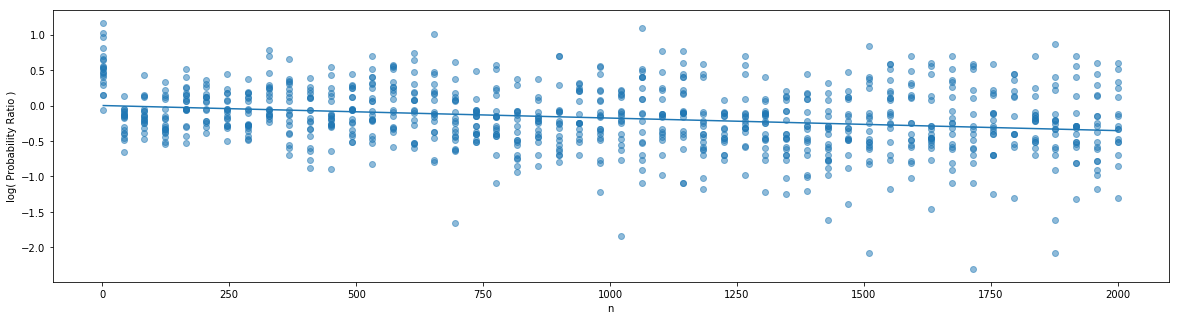

In [270]:
fig, ax = plt.subplots()
fig.set_size_inches([20,5])
ax.scatter(curveMelt.variable, curveMelt.value, alpha = .5)
ax.set_xlabel("n")
ax.set_ylabel("log( Probability Ratio )")
ax.plot(curveMelt.variable, smModel.fittedvalues)
fig.savefig("./ProbabilityRatio.pdf")

In [4]:
from cmc import *

In [2]:
from relativeEfficiencyLib import *

In [4]:
range(1, 5)

[1, 2, 3, 4]

In [5]:
[np.linspace( e, e + 2, 10, endpoint=False) for e in range(1, 5)]

[array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8]),
 array([2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8]),
 array([4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8])]

In [6]:
ALPHA = None

In [9]:
if ALPHA:
    print(2)

2


In [8]:
ALPHA = [np.linspace( e, e + 2, 10, endpoint=False) for e in range(1, 5)]